### Notebook 2 – Clustering of Conington Coins with K-Means

In this section, K-Means clustering is used as an unsupervised method to group coins based on simple numeric features (for example diameter and mid-date). The aim is not to discover true historical groups, but to see whether purely geometric clusters in feature space line up in any way with archaeological categories such as regime or broad period.

**Goal:**
- explore numeric patterns using K‑means (exploratory only)
- explore distribution
- try simple clustering and classification

**Modeling Question:**

Can basic features group coins into meaningful clusters?

Why no Classification Tree? 



In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score


#### 2.0 Check data

In [85]:
coins = pd.read_csv("../data/Coins_clean.csv")
coins.head()

,PERIOD,CONTEXT,MATERIAL,COIN_TYPE,COIN_REGIME,RULER,COIN_EDATE,COIN_LDATE,DENOMINATION,DIAMETER,MINT,COIN_CONDITION,mid_date,date_span
0,99.0,320002,COPPER ALLOY,NaN,NaN,NaN,700.0,900.0,NaN,NaN,NaN,NaN,800.0,200.0
1,99.0,320002,COPPER ALLOY,COPY,R,CONSTANTIUS II,330.0,335.0,NaN,16.0,TRIER,NaN,332.5,5.0
2,99.0,320002,SILVER,COIN,E,NaN,1066.0,1485.0,NaN,9.0,NaN,CUTQ,1275.5,419.0
3,99.0,320002,COPPER ALLOY,COIN,R,VALENTINIAN I,364.0,365.0,NUMMUS,20.0,ARLES,NaN,364.5,1.0
4,99.0,320002,COPPER ALLOY,JETTON,N,NaN,1550.0,1635.0,NaN,24.0,NaN,NaN,1592.5,85.0



#### 2.1 Select numeric features

K-Means relies on Euclidean distance, so all input variables should be on a comparable scale.

As numeric features I select DIAMETER and mid_date so each coin is a point in 2D “size–date” space, which is easy to visualise and interpret archaeologically.

#### 2.2 Standardizing the data
Diameter and mid_date use different units, so one could dominate the distance calculation.
Z‑score standardization rescales both to mean 0 and variance 1, so K‑Means treats them equally.

In [86]:
features = ["mid_date", "DIAMETER"]  #dropped date_span 
coins_num = coins[features].dropna() #drop rows with missing values

print("Rows for clustering:", len(coins_num))
coins_num.describe()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(coins_num)


Rows for clustering: 43


***Note*** I dropped date_span here to make the geometry simpler and archaeological interpretation more clear.

#### 2.3.Choose K with Elbow method
For each k, I fit K‑Means and record the inertia (within‑cluster sum of squares).
Plotting inertia against k lets me look for an “elbow” where adding more clusters gives diminishing returns in explaining variation.
This helps me choosing a good number for my cluster (k)

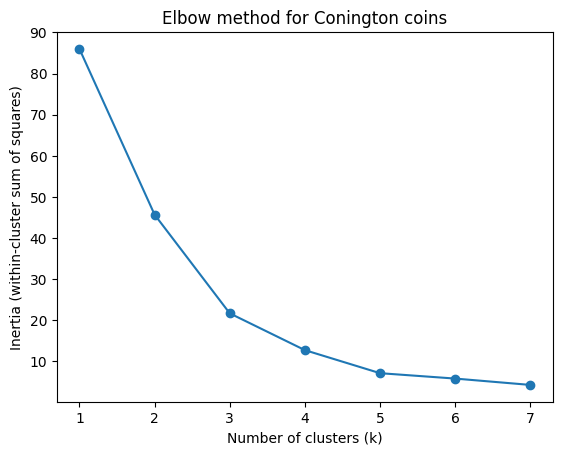

In [87]:
inertia = []
k_range = range(1, 8) 

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("Elbow method for Conington coins")
plt.show()


The “elbow” is where inertia still decreases but much more slowly. A good k could work a 3 or 4.

#### 2.4 Choose K with Silhouette scores
Because the elbow can be hard to read, I also use silhouette scores for different k.
The k with the highest silhouette score indicates more compact, well‑separated clusters, which helps justify my final choice.

In [88]:
from sklearn.metrics import silhouette_score

for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    print(f"k={k}, silhouette={sil:.3f}")

k=2, silhouette=0.579
k=3, silhouette=0.644
k=4, silhouette=0.656
k=5, silhouette=0.577
k=6, silhouette=0.549


#### 2.5 K-Means
I fix k = 4 because it has the highest silhouette score, meaning coins are relatively compact within clusters and well separated from others and then attach the cluster labels back to the original diameter–date values to interpret the 4 groups archaeologically.

In [95]:
k_final = 3
km = KMeans(n_clusters=k_final, random_state=42, n_init=10)
labels = km.fit_predict(X)

# Attach labels back to the original (unscaled) data
coins_num["cluster"] = labels
coins_num.head()

,mid_date,DIAMETER,cluster
1,332.5,16.0,0
2,1275.5,9.0,1
3,364.5,20.0,0
4,1592.5,24.0,1
6,1592.5,20.0,1


#### 2.6 PLot Clusters
This plot shows each coin positioned by its mid‑date and diameter, coloured by its cluster.
The pattern helps interpret whether clusters correspond to different chronological and size regimes in coin use at Conington.

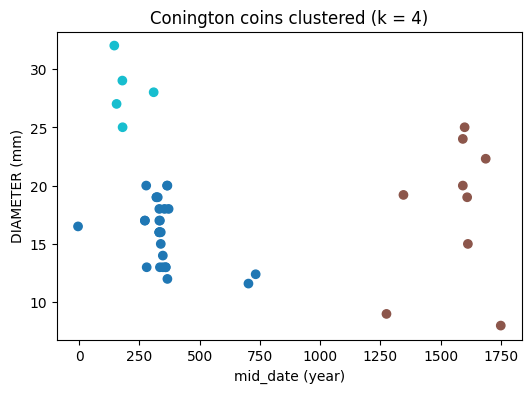

In [96]:
plt.figure(figsize=(6, 4))
scatter = plt.scatter(
    coins_num["mid_date"],
    coins_num["DIAMETER"],
    c=coins_num["cluster"],
    cmap="tab10"
)
plt.xlabel("mid_date (year)")
plt.ylabel("DIAMETER (mm)")
plt.title("Conington coins clustered (k = 4)")
plt.show()

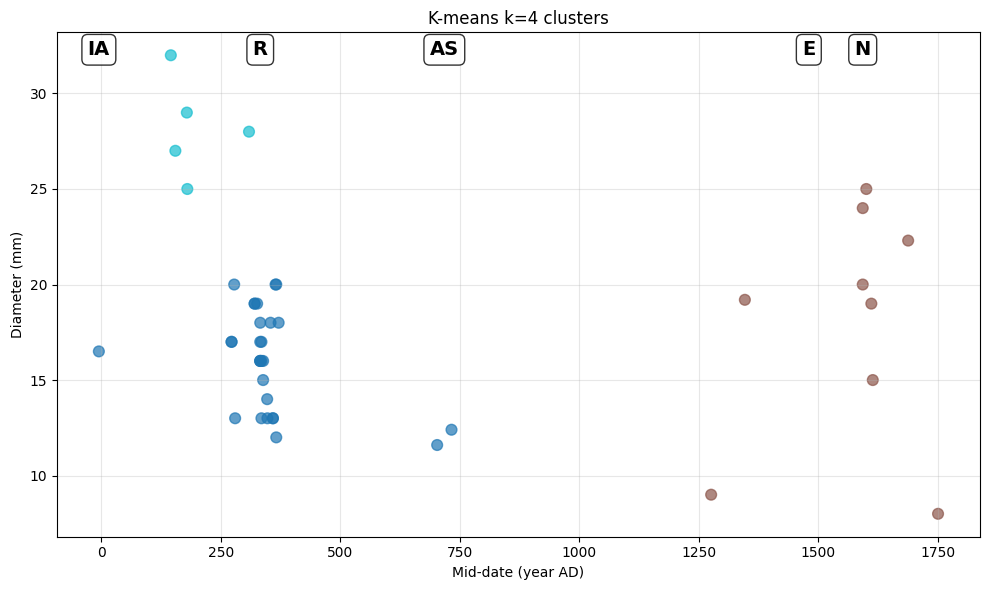

In [108]:
# Add regime to coins_num first
coins_num["regime"] = coins.loc[coins_num.index, "COIN_REGIME"]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    coins_num["mid_date"], 
    coins_num["DIAMETER"], 
    c=coins_num["cluster"], 
    cmap="tab10", 
    alpha=0.7,
    s=60
)

# Add regime labels at median positions
regime_medians = coins_num.groupby("regime")["mid_date"].median()
for regime, mid_date in regime_medians.items():
    plt.annotate(regime, 
                xy=(mid_date, 28), 
                xytext=(mid_date, 32),
                fontsize=14, fontweight='bold',
                ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.xlabel("Mid-date (year AD)")
plt.ylabel("Diameter (mm)")
plt.title("K-means k=4 clusters")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



#### Interpretation
Using diameter and mid‑date, the k‑means with k = 4 separates the Conington coins into two main Roman groups and a smaller later component. 
1.  The dense cluster of medium‑sized coins dating to roughly the third–fourth centuries represents the core Roman small‑change assemblage
2.  The second cluster of larger coins of similar date reflects higher‑value Roman denominations
3. Two smaller clusters of later, medieval to post‑medieval coins (one mainly small and one larger in diameter) suggest later intrusive losses rather than a continuous sequence of coin use at the site.

-> with k-means 3 it clusters the left side all together and the middle with mid-date 750 as one cluster (but not always?!)
-> interpret why diamter in roman coins is changing and no bigger coins are found later (are they less valuable or change in size and value later?)

- interpretation: 
- there is one IA coin with a diameter of (...) -> check if normal size
- most of the later ones are medieval and post medival which are small to middle big 
- there have been 5 roman coins found which are quite big
- look for images

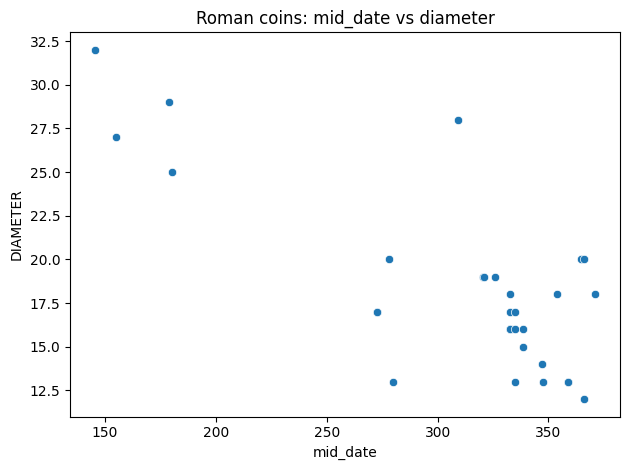

In [116]:
roman = coins[coins["COIN_REGIME"] == "R"]

# Dating vs size for Roman coins
sns.scatterplot(data=roman, x="mid_date", y="DIAMETER")
plt.title("Roman coins: mid_date vs diameter")
plt.tight_layout()
plt.show()

#### 2.7 Comparing clusters to regimes/archaeological category

If each cluster is dominated by one regime (for example, mostly Roman vs mostly late/post‑medieval), this suggests that the k‑means groups capture meaningful chronological and historical differences rather than purely statistical/numerical patterns.

In [109]:
# Align clustered rows with original data
df_clustered = coins_num.copy()  # has mid_date, DIAMETER, cluster

# Compare clusters with coin regimes
regime_cluster = pd.crosstab(
    coins.loc[df_clustered.index, "COIN_REGIME"],
    df_clustered["cluster"]
)
print(regime_cluster)
      

cluster       0  1  2
COIN_REGIME          
AS            2  0  0
E             0  4  0
IA            1  0  0
N             0  3  0
R            26  0  5


... looks fine: Cluster 0 is Roman (26 R, plus 1 IA and 2 AS), Cluster 2 is entirely medieval/post‑medieval (3 N, 2 E) → clearly the later component, Clusters 1 and 3 are tiny but also dominated by single regimes (E and R), so they look like small, coherent sub‑groups rather than random mixes.
... K-means on Roman-only data produces weak silhouette scores (<0.5) because coins follow seriation gradients, not Euclidean clusters. Lockyear (2022) demonstrates Correspondence Analysis recovers coin chronologies better by modelling the "empty upper triangle" where later coins never precede earlier ones in closed assemblages.

In [110]:
# Filter Roman coins from cluster 0
roman_coins = coins_clustered[
    (coins_clustered["COIN_REGIME"] == "R") & 
    (coins_clustered["cluster"] == 0)
].copy()

print(f"Roman coins in cluster 0: {len(roman_coins)}")
print("\nDate range:", roman_coins["mid_date"].agg(['min', 'max', 'mean']))
roman_coins[["RULER", "DENOMINATION", "MATERIAL", "mid_date"]].groupby("RULER").size()


Roman coins in cluster 0: 26

Date range: min     272.500000
max     371.000000
mean    332.653846
Name: mid_date, dtype: float64


RULER
CONSTANS          1
CONSTANTINE I     5
CONSTANTIUS II    2
GALLUS            1
TETRICUS I        3
VALENTINIAN I     1
dtype: int64

Q: 
- Did K-Means clustering added new information beyond my EDA?
- Can I see supattern in roman coins?
- Do certain rulers appear mainly in one cluster
- focus on roman coins and see if there are sub patterns?

Limitations
- Small sample size after dropping missing values.
- Only a few numeric features available.
- K‑means assumes spherical clusters and is sensitive to scaling.
- Results are exploratory, not definitive.



#### Ideas for Next Steps: 
- try a roman vs non-roman classification (exploratory) with sub-labels (problem is very sparse data in coin-type, denomination, ruler...)
- binary classification roman vs non roman (mid date, date span, diameter)
- try seriation

K-means on Roman-only data produces weak silhouette scores (<0.5) because coins follow seriation gradients, not Euclidean clusters. Lockyear (2022) demonstrates Correspondence Analysis recovers coin chronologies better by modelling the "empty upper triangle" where later coins never precede earlier ones in closed assemblages.

### Classification Conclusion + Limitations

A simple logistic regression using `mid_date`, `date_span`, and `DIAMETER` can separate Roman from non‑Roman coins reasonably well in cross‑validation.  
ROC‑AUC and Precision–Recall suggest meaningful signal, but performance is unstable due to the very small, imbalanced dataset.

**Limitations**
- Only ~41 labeled rows are usable.
- Class imbalance (many more Roman than non‑Roman).
- Cross‑validation results may vary with different splits.
- Model is exploratory and not suitable for real predictive claims.


## 4. Discussion 
- why no linear regression 
- why no decision tree
...


In [118]:

coins["Settlement"] = coins.apply(assign_settlement, axis=1)

KeyError: 'Period'